# Curriculumn Vitae Analysis

Want to create a model that can recognise search inputs and match those to the csv text data. My process for achieving this involves:

1) __Cleaning the data__: Removing stop words, stemming the data, removing paragraphs
2) __Tokenisation & Embed__: Using BERT LLM to to vectorise the data
3) __BERT Query Vectors__: Use BERTS query vector to provide a list of csvs that share "semantic value"

I would also like to use Open AI's model and instead of these steps we simply use:

1) __Zero-prompt Model__: Just throw the information at Open AI and see how it does
2) __Few-prompt Model__: Provide the instructions and some examples to show how to get the correct CV.

At the end of this process I would like to see the relative performance. I suspect that open Ai would be better, but would taken a very long time to parse through the data. I think vector queries would be the way to approach the problem.

## Exploratory Analysis

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../data/UpdatedResumeDataSet.csv")

We can see that this has a good spread of csv types. I don't think we will use the category, but it is useful to see the spread of information.

In [3]:
df.category.value_counts()

category
Java Developer               13
Data Science                 11
Database                     11
Advocate                     10
HR                           10
DotNet Developer              7
Hadoop                        7
DevOps Engineer               7
Automation Testing            7
Testing                       7
Civil Engineer                6
Business Analyst              6
SAP Developer                 6
Health and fitness            6
Python Developer              6
Arts                          6
Electrical Engineering        5
Sales                         5
Network Security Engineer     5
Mechanical Engineer           5
ETL Developer                 5
Blockchain                    5
Operations Manager            4
Web Designing                 4
PMO                           3
Name: count, dtype: int64

In [4]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import warnings; warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS

Would be interesting to see what the spread of the data is like, want to see how much difference there is between different tags

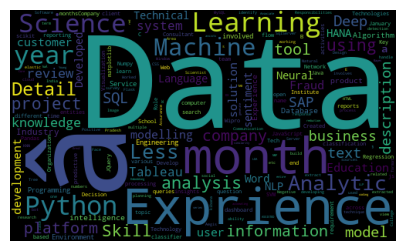

In [5]:
# Most frequent tokens for each tag
tag="Data Science"
plt.figure(figsize=(10, 3))
subset = df[df.category==tag]
text = subset.resume.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

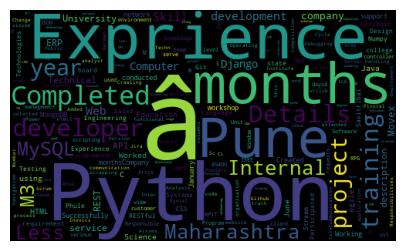

In [6]:
# Most frequent tokens for each tag
tag="Python Developer"
plt.figure(figsize=(10, 3))
subset = df[df.category==tag]
text = subset.resume.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

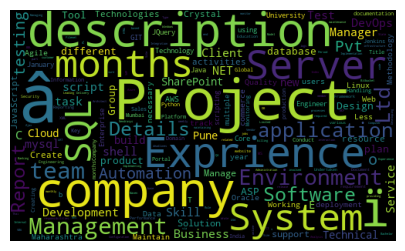

In [7]:
# Most frequent tokens for each tag
tag="DevOps Engineer"
plt.figure(figsize=(10, 3))
subset = df[df.category==tag]
text = subset.resume.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

Having seen these snippets it has given me confidence that there is a difference between categories in the data. Even for fields that are simiar. Now we need to convert the data into a JSON and clean.

## Cleaning Word Data:
### Stemming &Tokenisation

In [8]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [9]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jtren\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
def remove_duplicate_words(text):
    """
    Remove duplicate words from the text, preserving the original order.
    """
    words = text.split()
    seen = set()
    seen_add = seen.add
    # Preserve order and remove duplicates
    words_no_duplicates = [word for word in words if not (word in seen or seen_add(word))]
    return ' '.join(words_no_duplicates)

In [11]:
def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = re.sub("\n", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links
    text = remove_duplicate_words(text)
    
    return text # Apply to dataframe

In [12]:
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained('bert-base-uncased')

In [13]:
def tokenize(text):
    encoded_inputs = tokenizer(text, return_tensors="pt", padding="longest", truncation=True, max_length=512)
    return encoded_inputs

In [14]:
def preprocess(df):
    df["cleaned_resume"] = df["resume"].apply(clean_text)  # Apply clean_text
    df["tokenized_data"] = df["cleaned_resume"].apply(lambda x: tokenize(x))  # Apply tokenize
    return df

In [15]:
processed_df = preprocess(df)

## Embedding
We need to then create the embeddings. These are tensor objects that contain the semantic information for each word.

In [16]:
def create_embeddings(tokenized_data):
    """Generate embeddings by averaging token embeddings (excluding padding tokens)."""
    input_ids = tokenized_data['input_ids']
    attention_mask = tokenized_data['attention_mask']
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        # Get the hidden states of all tokens
        last_hidden_states = outputs.last_hidden_state
        # Create a mask for ignoring padding tokens
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_states.size()).float()
        # Sum embeddings for each token, ignoring padding tokens, then divide by the number of non-padding tokens
        sum_embeddings = torch.sum(last_hidden_states * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)  # Prevent division by zero
        mean_embeddings = sum_embeddings / sum_mask
    
    return mean_embeddings

In [17]:
from tqdm.notebook import tqdm
tqdm.pandas(desc="Creating Embeddings")

In [18]:
df['embeddings'] = df['tokenized_data'].progress_apply(lambda row: create_embeddings(row))

Creating Embeddings:   0%|          | 0/167 [00:00<?, ?it/s]

In [19]:
from sklearn.preprocessing import normalize

df['normalized_embeddings'] = df['embeddings'].apply(lambda x: normalize(x.reshape(1, -1), axis=1).flatten())


## Vector Query
Now that we have created out embeddings, we can now query the data with a prompt

In [48]:
query_text = 'Python machine learning sklearn SQL'
query_tokenized = tokenize(query_text)  # Ensure this uses the same tokenizer and method used for CVs
query_embedding = create_embeddings(query_tokenized).numpy() 

In [49]:
embeddings_matrix = np.vstack(df['embeddings'].values)

In [50]:
from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity(query_embedding.reshape(1, -1), embeddings_matrix)

In [51]:
df['similarity_score'] = similarities[0]

In [52]:
sorted_df = df.sort_values(by='similarity_score', ascending=False).reset_index(drop=True)

In [53]:
sorted_df[['category', 'resume', 'similarity_score']]

,category,resume,similarity_score
0,DotNet Developer,TECHNICAL SKILLS â¢ Web Technologies: ASP .NE...,0.707913
1,Python Developer,TECHNICAL PROFICIENCIES Platform: Ubuntu/Fedor...,0.705824
2,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",0.704497
3,Java Developer,"Computer Skills: Languages And Script: JSP, Se...",0.697614
4,DotNet Developer,TECHNICAL SKILLS â Programming Languages: C#...,0.697326
...,...,...,...
162,Civil Engineer,Education Details \r\n B.E in Civil Engineerin...,0.461604
163,Mechanical Engineer,Education Details \r\nMay 1999 to September 20...,0.456067
164,Operations Manager,Education Details \r\n BCA Vinayaka Missions...,0.454583
165,Operations Manager,IT SKILLS â¢ Well versed with MS Office and I...,0.446310


In [55]:
sorted_df.iloc[4,1]

'TECHNICAL SKILLS â\x9d\x96 Programming Languages: C#.NET â\x9d\x96 Web Technologies: ASP.NET MVC, Web API, Angular, JQuery, HTML5, CSS3, Bootstrap. â\x9d\x96 Database: SQL Server 2014 â\x9d\x96 IDE: Visual Studio 2015, Visual Studio Code â\x9d\x96 Office Packages: MS-Office (Access, Word, Excel) Education Details \r\nJanuary 2016 B.Sc.(Computer Science)  Solapur, Maharashtra Solapur University\r\nDOT NET Developer \r\n\r\nDOT NET Developer - Navshar Global Software\r\nSkill Details \r\n.NET- Exprience - 15 months\r\nASP- Exprience - 15 months\r\nASP.NET- Exprience - 15 months\r\nBOOTSTRAP- Exprience - 15 months\r\njQuery- Exprience - 15 months\r\nASP.NET MVC- Exprience - Less than 1 year months\r\nAngularjs- Exprience - Less than 1 year months\r\nC#- Exprience - Less than 1 year months\r\nEntity Framework- Exprience - Less than 1 year monthsCompany Details \r\ncompany - Navshar Global Software\r\ndescription - 017.\r\n\r\nPROJECTS WORKED ON\r\n1. Navnirman Tech Festival\r\nâ\x9c\x93 N

Research looking at frequecy of words. Just as a learning point wanted to post what the enbeddings look like.